## Exploring BindingDB Data for PXR: A Cheminformatics Tutorial


### Introduction

This tutorial demonstrates how to work with BindingDB data to analyze protein-ligand binding interactions, focusing on the Pregnane X Receptor (PXR). We will:

1. Download and explore a subset of the BindingDB database
2. Query and process PXR-specific binding data 
3. Analyze data quality and consistency across different publications
4. Examine structural information from PDB
5. Build and evaluate a simple QSAR model

The tutorial showcases common cheminformatics tasks including:
- Database queries with DuckDB
- Chemical structure handling with RDKit
- Data visualization with Seaborn 
- Basic machine learning with LightGBM


In [1]:
try:
    import google.colab
    # Only run the package installation when in Colab environment
    !uv pip install rdkit duckdb pandas numpy seaborn matplotlib mols2grid scikit-learn lightgbm scipy wget tqdm
except ImportError:
    pass  # Not running in Colab


### Imports
We begin by importing the necessary libraries for our analysis. This includes tools for database access, data manipulation, cheminformatics, machine learning, and visualization. We also set up progress bars for better tracking of long-running operations and handle any warnings that may arise during the process.

In [2]:
# database access
import duckdb
# data tables
import pandas as pd
# handling matrices and arrays
import numpy as np
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
# chemiformatics 
import mols2grid
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import rdFingerprintGenerator
import useful_rdkit_utils as uru
# machine learning
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from scipy.stats import gmean
# removing annoying messages
import warnings
# progress bars 
from tqdm.auto import tqdm
# file downloads 
import wget
from pathlib import Path
# get info from the pdb
from download_pdb_ids import get_pdb_ids

### Initial Setup
Enable progress bars for Pandas dataframes 

In [3]:
tqdm.pandas()

### Define our protein target, PXR
The Pregnane X Receptor (PXR), a member of the nuclear receptor superfamily, plays a critical role in drug discovery as a primary mediator of xenobiotic metabolism. Often referred to as a "master regulator," PXR is activated by a diverse array of lipophilic compounds, including many therapeutic drugs. Once activated, it coordinates the transcriptional up-regulation of key Phase I and Phase II metabolic enzymes—most notably CYP3A4—as well as drug transporters like P-glycoprotein.

In a drug discovery context, PXR activation is frequently viewed as a significant liability; if a lead compound is a PXR agonist, it may induce the metabolism of itself or co-administered drugs. This leads to drug-drug interactions (DDIs), reduced therapeutic efficacy, or the production of toxic metabolites. Consequently, early-stage screening for PXR binding is a standard practice used to optimize the metabolic stability and safety profiles of clinical candidates.

We can identify PXR in BindingDB using its UniProt ID, which is **O75469**.  This identifier allows us to query the database for all compounds that have been tested for binding to PXR, along with their associated binding affinities and other relevant data. The following sections will guide us through the process of accessing and analyzing this data to gain insights into the chemical space of PXR ligands and their binding characteristics. The UniProt ID is a unique identifier for proteins in the UniProt database, and it provides a standardized way to reference specific proteins across various databases and studies. By using this ID, we can ensure that we are retrieving data specifically related to PXR from BindingDB, which will allow us to analyze the binding interactions and affinities of compounds targeting this receptor. This ID can be found in the [UniProt database](https://www.uniprot.org/uniprot/O75469) and is commonly used in bioinformatics and cheminformatics to link protein data across different resources.

In [4]:
uniprot_id = "O75469"

### Download the database file. 

Check to see whether the database file exists, if it doesn't, download it. Note that for this example, we're using a subset of **BindingDB**.  The full database is more that 2GB and would take a while to download.

In [5]:
file_path = Path("bindingdb_sample.ddb")

if not file_path.exists():
    url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/refs/heads/main/bindingdb/bindingdb_sample.ddb"
    fiiename = wget.download(url)

### Examine the database

BindingDB contains a lot of information, but the most critical can be found in the first 50 columns, let's take a look at those. 

In [6]:
con = duckdb.connect(file_path,read_only=True)
columns = con.table('bindingdb').columns
pd.DataFrame(columns[:50],columns=["Column Name"])

,Column Name
0,BindingDB Reactant_set_id
1,Ligand SMILES
2,Ligand InChI
3,Ligand InChI Key
4,BindingDB MonomerID
5,BindingDB Ligand Name
6,Target Name
7,Target Source Organism According to Curator or...
8,Ki (nM)
9,IC50 (nM)


### Define an SQL query to get the PXR data from BindingDB 

To access the data we need, we'll define an SQL query. Most of this query simply defines the columns we want to acess.  The most critical part is at the end where we define the **uniprot_id** we want to search for.

In [7]:
query = f"""select "Ligand SMILES","Ligand InChI Key",
    "BindingDB Ligand Name",
    "Target Name", 
    "Target Source Organism According to Curator or DataSource",
    "Article DOI", 
    "PDB ID(s) for Ligand-Target Complex",
    "EC50 (nM)" from bindingdb 
    where "UniProt (SwissProt) Primary ID of Target Chain 1" = '{uniprot_id}'"""

### Run the query and return the results as a Pandas dataframe

Here we execute our SQL query against the BindingDB database and store the results in a Pandas dataframe for further analysis. The query will retrieve data specifically related to PXR binding interactions using the UniProt ID we defined earlier.


In [8]:
res = con.execute(query)
res_df = res.df()

In [9]:
res_df.head()

,Ligand SMILES,Ligand InChI Key,BindingDB Ligand Name,Target Name,Target Source Organism According to Curator or DataSource,Article DOI,PDB ID(s) for Ligand-Target Complex,EC50 (nM)
0,c1ccc(cc1)S(=O)(=O)[N@@](CC(F)(F)F)c2ccc(cc2)C...,SGIWFELWJPNFDH-UHFFFAOYSA-N,"CHEMBL62136::[3H]T0901317::T 0901317::N-[4-(1,...",Nuclear receptor subfamily 1 group I member 2,Homo sapiens,10.1016/j.bmc.2006.12.026,"1UPV,1UPW,1PQC,5NTQ,4NB6,5K3L,1UHL,5EJV,2O9I",13
1,OC(c1ccc(cc1)N(CC(F)(F)F)S(=O)(=O)c1ccccc1)C(F...,YKHCWWRCGHFHFR-UHFFFAOYSA-N,"N-[4-(2,2,2-trifluoro-1-hydroxyethyl)phenyl]-N...",Nuclear receptor subfamily 1 group I member 2,Homo sapiens,10.1016/j.bmc.2006.12.026,None,1000
2,CC(O)(c1ccc(cc1)N(CC(F)(F)F)S(=O)(=O)c1ccccc1)...,DKJFEFWRUFUJLQ-UHFFFAOYSA-N,"N-[4-(1,1,1-trifluoro-2-hydroxypropan-2-yl)phe...",Nuclear receptor subfamily 1 group I member 2,Homo sapiens,10.1016/j.bmc.2006.12.026,None,501
3,CCC(O)(c1ccc(cc1)N(CC(F)(F)F)S(=O)(=O)c1ccccc1...,JXXXEUFWXBYGGF-UHFFFAOYSA-N,"N-[4-(1,1,1-trifluoro-2-hydroxybutan-2-yl)phen...",Nuclear receptor subfamily 1 group I member 2,Homo sapiens,10.1016/j.bmc.2006.12.026,None,126
4,CCCC(O)(c1ccc(cc1)N(CC(F)(F)F)S(=O)(=O)c1ccccc...,REGGUSMKWKQUJO-UHFFFAOYSA-N,"N-[4-(1,1,1-trifluoro-2-hydroxypentan-2-yl)phe...",Nuclear receptor subfamily 1 group I member 2,Homo sapiens,10.1016/j.bmc.2006.12.026,None,158


### Perform some preprocessing of the data

The next 3 cells prepare the data for analysis by:
1. Creating a boolean column 'has_operator' to identify EC50 values with > or < operators
2. Filtering out rows with missing EC50 values or those with operators
3. Converting EC50 values from nanomolar to pEC50 (-log10 of molar concentration)


In [10]:
res_df["has_operator"] = res_df["EC50 (nM)"].str.startswith((">","<"))

In [11]:
res_df = res_df.query("`EC50 (nM)`.notna() and has_operator == False")

In [12]:
res_df['pEC50'] = -np.log10(res_df["EC50 (nM)"].astype(float) * 1e-9)

### Examine the number of compounds available in each paper


In [13]:
ref_count_df = uru.value_counts_df(res_df,"Article DOI")
ref_dict = ref_count_df.set_index('Article DOI')['count'].to_dict()
ref_count_df.head(20)

,Article DOI,count
0,10.1124/dmd.110.035105,166
1,10.1021/acs.jmedchem.0c02201,66
2,10.1016/j.bmc.2008.02.020,31
3,10.1016/j.bmcl.2020.127392,29
4,10.1021/acs.jmedchem.9b01032,26
5,10.1016/j.bmcl.2017.12.006,24
6,10.1016/j.bmcl.2020.127441,20
7,10.1021/ml500144h,19
8,10.1021/acsmedchemlett.3c00210,18
9,10.1021/acsmedchemlett.9b00010,16


### Evaluate the EC<sub>50</sub> distributions for each paper

In [14]:
def aggregate_data(df):
    res_list = []
    for k,v in df.groupby("Ligand InChI Key"):
        res_list.append([v['Ligand SMILES'].values[0],gmean(v.pEC50)])
    return pd.DataFrame(res_list,columns=["SMILES","pEC50"])

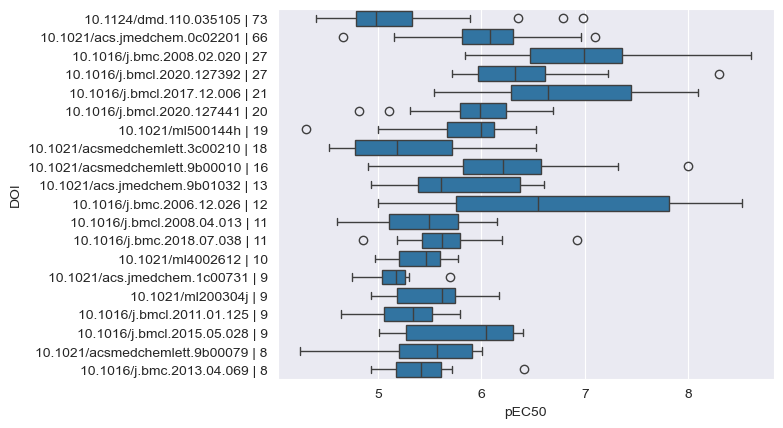

In [15]:
assay_df_list = []
y_label_list = []
for doi in ref_count_df["Article DOI"].head(20):
    doi_df = res_df.query("`Article DOI`== @doi")  
    agg_df = aggregate_data(doi_df)
    label = f"{doi} | {len(agg_df)}"
    agg_df['label'] = label
    y_label_list.append([label,len(agg_df)])
    assay_df_list.append(agg_df) 
combo_df = pd.concat(assay_df_list).reset_index(drop=True)
y_label_df = pd.DataFrame(y_label_list,columns=["label","count"]).sort_values("count",ascending=False)
ax = sns.boxplot(x="pEC50",y="label",data=combo_df,order=y_label_df.label)
ax.set_ylabel("DOI");

### Evaluate the chemical diversity of the compounds from each paper



In [16]:
def get_max_tanimoto_similarities(smiles_list, radius=2, nBits=2048):
    """
    Calculates the maximum Tanimoto similarity for each molecule 
    compared to all other molecules in the provided SMILES list
    using the modern MorganGenerator.
    """
    # 1. Convert SMILES to RDKit Mol objects
    mols = [Chem.MolFromSmiles(s) for s in smiles_list]
    valid_mols = [m for m in mols if m is not None]
    
    if not valid_mols:
        return []

    # 2. Initialize the Morgan Fingerprint Generator
    # Note: radius=2 in the old method corresponds to fpSize=2 in the generator
    generator = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=nBits)
    
    # 3. Generate fingerprints
    fps = [generator.GetFingerprint(m) for m in valid_mols]
    
    max_similarities = []
    
    # 4. Compare each fingerprint against all others
    for i, fp_target in enumerate(fps):
        # Using BulkTanimotoSimilarity for better performance
        others = fps[:i] + fps[i+1:]
        
        if not others:
            max_similarities.append(0.0)
            continue
            
        sims = DataStructs.BulkTanimotoSimilarity(fp_target, others)
        max_similarities.append(max(sims))
        
    return max_similarities

In [17]:
sim_df_list = []
for k,v in combo_df.groupby("label"):
    smiles_list = v.SMILES
    sim_list = get_max_tanimoto_similarities(smiles_list)
    sim_df = pd.DataFrame(sim_list,columns=["sim"])
    sim_df['label'] = k
    sim_df_list.append(sim_df)
sim_combo_df = pd.concat(sim_df_list)

As we can see in the plot below, most of the papers focus on a relatively narrow chemical space, with many compounds having high similarity to at least one other compound in the same paper. This is a common pattern in medicinal chemistry, where researchers often explore analogs of a few core scaffolds. The boxplot shows the distribution of maximum Tanimoto similarities for compounds within each paper, ordered by the number of compounds reported. Papers with a larger number of compounds tend to have higher maximum similarities, indicating that they may be exploring more focused chemical series.

<Axes: xlabel='sim', ylabel='label'>

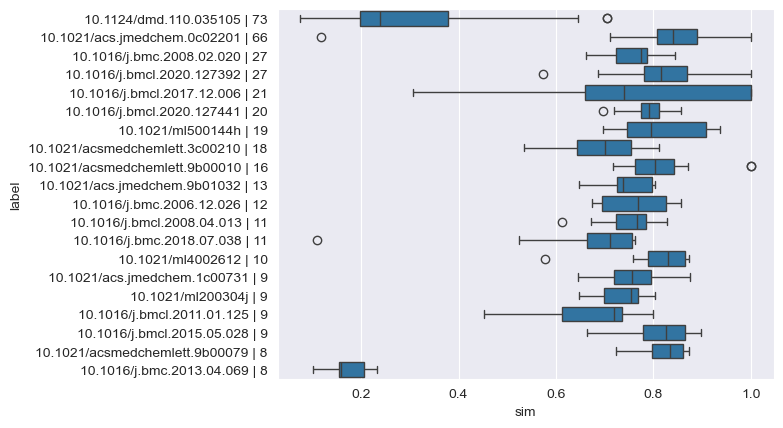

In [18]:
sns.boxplot(x="sim",y="label",data=sim_combo_df,order=y_label_df.label)

### Determine which papers have PDB structures available for their compounds.

This is important because having structural information can provide insights into the binding interactions and help guide drug design efforts. We will use the list of PDB IDs associated with each compound in the BindingDB data and check which of those IDs correspond to structures that include PXR as a target.  BindingDB provides a column "PDB ID(s) for Ligand-Target Complex" that lists the PDB IDs of any structures that include the ligand and target complex. We will extract these IDs and check them against the list of PDB IDs known to be associated with PXR to identify which papers have structural data available for their compounds.  The function `get_pdb_ids` is used to retrieve the list of PDB IDs associated with PXR, and we will compare this list to the PDB IDs listed in the BindingDB data for each compound to determine which papers have relevant structural information.


In [19]:
pxr_id_list = get_pdb_ids(uniprot_id)
pxr_id_set = set([x.upper() for x in pxr_id_list])

Create a new column in our results dataframe that contains the list of PDB IDs for each compound that are associated with PXR. We will check the "PDB ID(s) for Ligand-Target Complex" column for each compound, split it into individual IDs, and then check if any of those IDs are in our set of PXR-associated PDB IDs. If there are matches, we will store the list of matching PDB IDs in the new column; otherwise, we will store None.

In [20]:
pxr_pdb_list = []
for r in res_df["PDB ID(s) for Ligand-Target Complex"]:
    if r is None:
        pxr_pdb_list.append(None)
    else:
        id_list = r.split(",")
        ok_list = [x for x in id_list if x in pxr_id_set]
        if len(ok_list):
            pxr_pdb_list.append(ok_list)
        else:
            pxr_pdb_list.append(None)

In [21]:
res_df['pxr_pdb'] = pxr_pdb_list

In [22]:
xray_df = res_df.dropna(subset="pxr_pdb")[["Ligand SMILES","Article DOI","pxr_pdb"]].dropna().drop_duplicates(subset="Article DOI")

In [23]:
mols2grid.display(xray_df,smiles_col="Ligand SMILES",subset=["img","pxr_pdb"])

MolGridWidget()

### Aggregate the pEC50 values and examine assay variability across papers
Aggregate the data by ligand and calculate the geometric mean of the pEC50 values for each ligand across all papers. This will give us a single representative pEC50 value for each unique ligand, which we can then use for further analysis and modeling. We will group the data by the "Ligand InChI Key" to ensure that we are aggregating data for the same chemical entity, and then calculate the geometric mean of the pEC50 values for each group. The resulting dataframe will contain one row per unique ligand, with its corresponding SMILES string and aggregated pEC50 value.

Create a new dataframe that contains only the compounds that do not have any operators (i.e., those that do not have ">" or "<" in their EC50 values). We will then count the number of unique ligands based on their InChI Keys and sort them by count to identify which ligands have been tested most frequently across the different papers. This will help us understand which compounds have the most data available for analysis and may be of particular interest for further study or modeling efforts.

In [43]:
res_df_ok = res_df.query("has_operator == False").copy()
ligand_count_df = uru.value_counts_df(res_df_ok,"Ligand InChI Key")
ligand_count_df.sort_values("count",ascending=False,inplace=True)

Plot the variability for the top 5 most frequently tested ligands across the different papers. We will create a point plot for each of these ligands, showing the distribution of pEC50 values reported in the different studies. This will allow us to visually assess the consistency of the binding affinity measurements for these compounds and identify any potential outliers or discrepancies in the data. By examining the variability in pEC50 values for the most commonly tested ligands, we can gain insights into the reliability of the assay data and the potential influence of experimental conditions on the reported binding affinities.

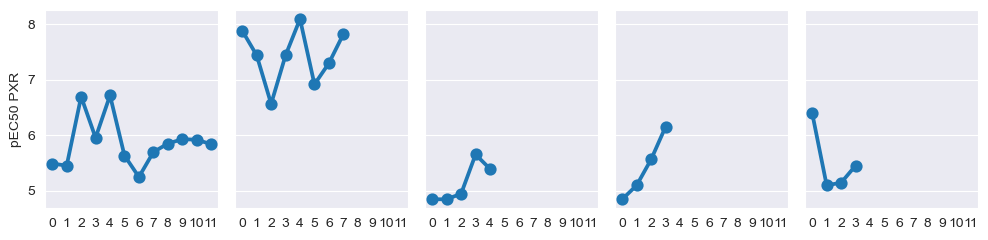

In [28]:
figure, axes = plt.subplots(1,5,figsize=(10,2.5),sharex=True,sharey=True)
for i,inchi in enumerate(ligand_count_df.head(5)["Ligand InChI Key"]):
    vals = res_df_ok.query("`Ligand InChI Key` == @inchi").pEC50.values
    ax = sns.pointplot(vals,ax=axes[i])
    ax.set_label("Sample #")
    ax.set_ylabel("pEC50 PXR")
plt.tight_layout()

Aggregate the pEC50 values for each unique ligand by calculating the geometric mean across all measurements for that ligand. This will give us a single representative pEC50 value for each ligand, which can be used for further analysis and modeling. We will group the data by "Ligand InChI Key" to ensure that we are aggregating data for the same chemical entity, and then calculate the geometric mean of the pEC50 values for each group. The resulting dataframe will contain one row per unique ligand, with its corresponding SMILES string and aggregated pEC50 value.

In [29]:
agg_list = []
for k,v in res_df_ok.groupby("Ligand InChI Key"):
    gmean_val = gmean(v.pEC50.values)
    smiles = v["Ligand SMILES"].values[0]
    agg_list.append([smiles,gmean_val])
agg_df = pd.DataFrame(agg_list,columns=["SMILES","pEC50"])

Plot the distribution of the aggregated pEC50 values to examine the overall range and central tendency of the binding affinities for the compounds in our dataset. This will help us understand the variability in binding affinities and identify any potential outliers or trends in the data. The distribution can be visualized using a histogram or a kernel density plot, which will show us how the pEC50 values are distributed across the compounds we have aggregated from the different papers.

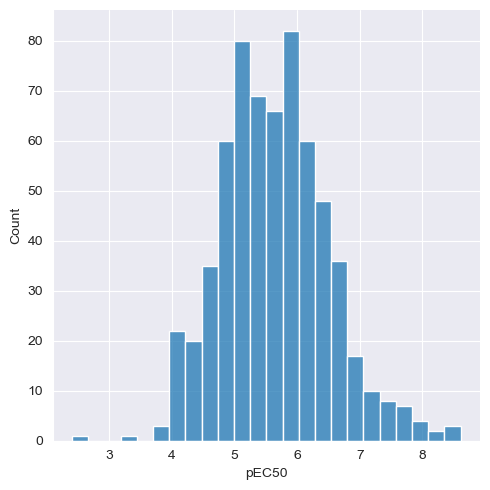

In [30]:
sns.displot(agg_df.pEC50)

### Build a simple QSAR model to predict pEC50 values based on chemical structure
We will use the RDKit library to calculate molecular descriptors from the SMILES strings, and then train a LightGBM regression model to predict the pEC50 values. The model will be evaluated using the R-squared metric to assess how well it can explain the variance in the pEC50 values based on the chemical features of the compounds. This will allow us to understand the relationship between chemical structure and binding affinity for PXR, and potentially identify key structural features that contribute to stronger or weaker binding interactions.

In [31]:
rdkit_desc = uru.RDKitDescriptors()
agg_df['desc'] = agg_df["SMILES"].progress_apply(rdkit_desc.calc_smiles)

  0%|          | 0/634 [00:00<?, ?it/s]

Split the data into training and testing sets to evaluate the performance of our QSAR model. We will use the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from scikit-learn to randomly split the aggregated dataframe into a training set, which will be used to train the LightGBM regression model, and a testing set, which will be used to evaluate the model's predictive performance. This step is crucial for assessing how well our model generalizes to unseen data and for preventing overfitting.

In [32]:
train, test = train_test_split(agg_df)

Instantiate the LightGBM regression model, train it on the training data, and then use it to make predictions on the test set. We will fit the model using the molecular descriptors as input features and the pEC50 values as the target variable. After training, we will predict the pEC50 values for the test set and evaluate the model's performance using the R-squared metric to determine how well it can explain the variance in the pEC50 values based on the chemical structure of the compounds.

In [38]:
lgbm = LGBMRegressor(verbose=-1)
lgbm.fit(np.stack(train.desc),train.pEC50)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pred = lgbm.predict(np.stack(test.desc))

Calculate the R-squared value to evaluate the performance of our QSAR model. The R-squared metric will indicate how well the model's predictions match the actual pEC50 values in the test set, with a value of 1 indicating perfect predictions and a value of 0 indicating that the model does not explain any of the variance in the data. This will help us understand the effectiveness of our model in capturing the relationship between chemical structure and binding affinity for PXR.

In [39]:
r2 = r2_score(test.pEC50,pred)
r2

0.47575111391115743

Plot the predicted pEC50 values against the actual pEC50 values from the test set to visually assess the performance of our QSAR model. We will use a regression plot to show the relationship between the predicted and actual values, and we will also annotate the plot with the R-squared value to provide a quantitative measure of the model's performance. This visualization will help us identify any systematic deviations or patterns in the predictions, as well as assess how well the model captures the underlying trends in the data.

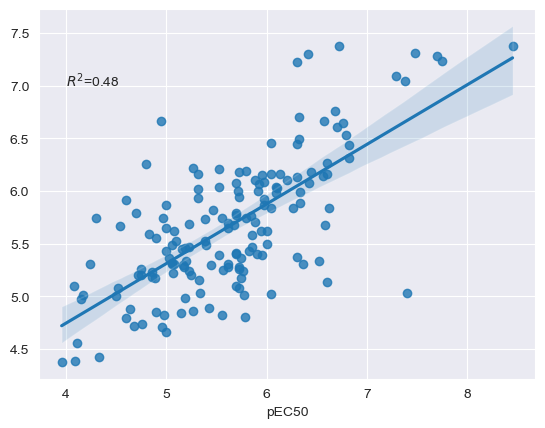

In [40]:
ax = sns.regplot(x=test.pEC50,y=pred)
ax.text(4,7,f"$R^2$={r2:.2f}");

To evaluate the stability and robustness of our QSAR model, we will perform multiple iterations of training and testing by randomly splitting the data into different training and testing sets. For each iteration, we will train a new LightGBM regression model and calculate the R-squared value for the test set. By repeating this process multiple times (e.g., 10 iterations), we can generate a distribution of R-squared values that will allow us to assess the variability in model performance due to different data splits. This will provide insights into how well our model generalizes across different subsets of the data and help us identify any potential issues with overfitting or underfitting.

In [41]:
r2_list = []
for i in tqdm(range(0,10)):
    train, test = train_test_split(agg_df)
    lgbm = LGBMRegressor(verbose=-1)
    lgbm.fit(np.stack(train.desc),train.pEC50)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",category=UserWarning)
        pred = lgbm.predict(np.stack(test.desc))    
    r2 = r2_score(test.pEC50,pred)
    r2_list.append(r2)

  0%|          | 0/10 [00:00<?, ?it/s]

Finally,  we'll plot the distribution of R-squared values obtained from the multiple iterations of training and testing our QSAR model. This will allow us to visually assess the variability in model performance across different data splits and understand the stability of our model's predictions. We will use a point plot to show the range of R-squared values, and we will set the y-axis limits to focus on the relevant range of values for better visualization.

(0.0, 1.0)

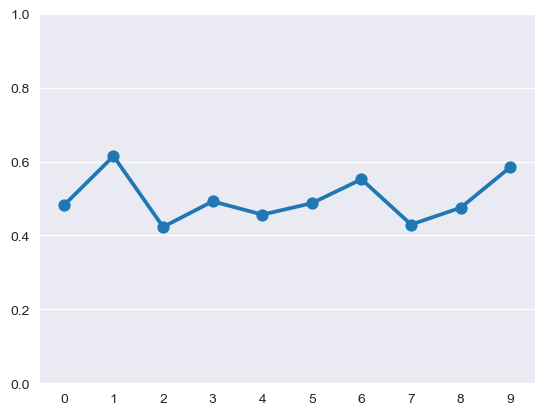

In [42]:
ax = sns.pointplot(r2_list)
ax.set_ylim(0,1)

In [44]:
!pwd

/Users/pwalters/DATA/BINDING_DB
